<a href="https://colab.research.google.com/github/danielngec/DashboardRH/blob/main/Manuten%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from imblearn.under_sampling import RandomUnderSampler

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, silhouette_score, jaccard_score, rand_score, silhouette_samples
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
def basic_preprocess(df):
    df = df.replace('na', np.nan)
    for column in df.columns:
        if column != 'class':
            df[column] = df[column].astype(np.float64)
    df['class'] = np.where(df['class'] == 'pos', 1, 0)
    return df

In [ ]:
def preprocess(train, test):
    most_null = train.loc[:, train.isnull().mean() > .5].keys()
    train.drop(columns=most_null, inplace=True)
    test.drop(columns=most_null, inplace=True)

    y_train = train['class']
    y_test = test['class']

    train = train.map(lambda x: np.log(x + 1) if not np.isnan(x + 1) else np.nan)
    test = test.map(lambda x: np.log(x + 1) if not np.isnan(x + 1) else np.nan)

    corr = train.corr(method='pearson')
    corr = corr.abs().unstack().reset_index()
    corr = corr.sort_values(by=[0], ascending=False)
    corr = corr[(corr[0]> 0.8) & (corr['level_0'] != corr['level_1']) ]
    corr = corr['level_0'].unique()

    train.drop(columns=corr, inplace=True)
    test.drop(columns=corr, inplace=True)

    scaler = StandardScaler()
    scaler.fit(train)
    train[train.columns] = scaler.transform(train[train.columns])
    test[test.columns] = scaler.transform(test[test.columns])

    #imputer = SimpleImputer()
    #imputer.fit(X_train)
    #X_train[X_train.columns] = imputer.transform(X_train[X_train.columns])
    #X_test[X_test.columns] = imputer.transform(test[X_test.columns])

    train = train.fillna(0)
    test = test.fillna(0)

    train['class'] = y_train
    test['class'] = y_test

    return train, test

In [ ]:
train = pd.read_csv('air_system_previous_years.csv')
train = basic_preprocess(train)

test = pd.read_csv('air_system_present_year.csv')
test = basic_preprocess(test)

In [ ]:
train

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,76698.0,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,0,33058.0,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,0,41040.0,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,0,12.0,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,0,60874.0,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,153002.0,NaN,6.640000e+02,186.0,0.0,0.0,0.0,0.0,0.0,...,998500.0,566884.0,1290398.0,1218244.0,1019768.0,717762.0,898642.0,28588.0,0.0,0.0
59996,0,2286.0,NaN,2.130707e+09,224.0,0.0,0.0,0.0,0.0,0.0,...,10578.0,6760.0,21126.0,68424.0,136.0,0.0,0.0,0.0,0.0,0.0
59997,0,112.0,0.0,2.130706e+09,18.0,0.0,0.0,0.0,0.0,0.0,...,792.0,386.0,452.0,144.0,146.0,2622.0,0.0,0.0,0.0,0.0
59998,0,80292.0,NaN,2.130706e+09,494.0,0.0,0.0,0.0,0.0,0.0,...,699352.0,222654.0,347378.0,225724.0,194440.0,165070.0,802280.0,388422.0,0.0,0.0


In [ ]:
train['class'].value_counts()

,count
class,
0,59000
1,1000


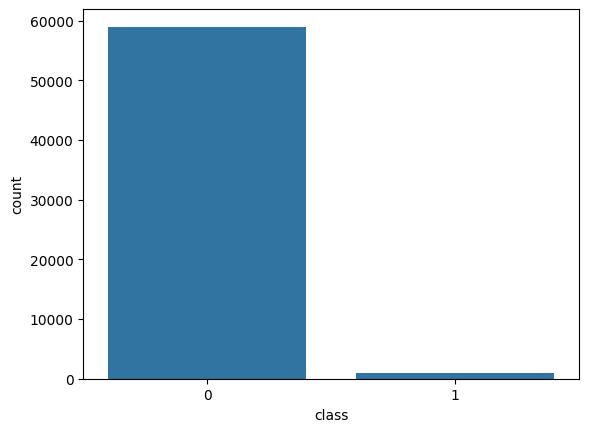

In [ ]:
sns.countplot(data=train, x=train['class']);

In [ ]:
train.loc[:, train.isnull().mean() > .5].keys()

Index(['ab_000', 'bm_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000',
       'cr_000'],
      dtype='object')

In [ ]:
train, test = preprocess(train, test)

In [ ]:
train

,class,ac_000,ag_000,ag_001,ag_009,ai_000,aj_000,ak_000,ar_000,as_000,...,cy_000,cz_000,da_000,db_000,de_000,dz_000,ea_000,eb_000,ef_000,eg_000
0,0,2.111922,-0.052576,-0.106756,-0.645056,-0.321895,-0.494046,-0.079173,-0.186242,-0.018142,...,-0.380832,2.027499,-0.10484,1.006550,1.612408,-0.061472,-0.099612,0.765621,-0.056305,-0.080072
1,0,-0.997205,-0.052576,-0.106756,-0.645056,-0.321895,1.545194,-0.079173,-0.186242,-0.018142,...,0.000000,0.000000,0.00000,0.000000,1.006723,-0.061472,-0.099612,0.794909,-0.056305,-0.080072
2,0,-0.210690,-0.052576,-0.106756,-0.645056,-0.321895,-0.494046,-0.079173,-0.186242,-0.018142,...,1.542464,1.186580,-0.10484,-0.787530,0.037019,-0.061472,-0.099612,0.631514,-0.056305,-0.080072
3,0,-0.380195,-0.052576,-0.106756,-0.645056,-0.321895,-0.494046,-0.079173,-0.186242,-0.018142,...,-0.380832,-0.708057,-0.10484,-0.787530,-0.662998,-0.061472,-0.099612,-1.243948,11.238171,15.989228
4,0,0.048134,-0.052576,-0.106756,-0.645056,-0.321895,2.118731,-0.079173,-0.186242,-0.018142,...,-0.380832,0.784004,-0.10484,-0.787530,0.879306,-0.061472,-0.099612,1.039422,-0.056305,-0.080072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,-0.056380,-0.052576,-0.106756,2.011096,-0.321895,2.221512,-0.079173,2.344298,-0.018142,...,-0.380832,-0.083319,-0.10484,-0.787530,1.889376,-0.061472,-0.099612,1.219574,-0.056305,-0.080072
59996,0,2.111922,-0.052576,-0.106756,-0.645056,-0.321895,-0.494046,-0.079173,-0.186242,-0.018142,...,-0.380832,-0.610311,-0.10484,0.673535,-0.741956,-0.061472,-0.099612,0.660237,-0.056305,-0.080072
59997,0,2.111922,-0.052576,-0.106756,-0.645056,-0.321895,-0.494046,-0.079173,-0.186242,-0.018142,...,-0.380832,-0.024097,-0.10484,-0.787530,-0.525446,-0.061472,-0.099612,-1.243948,-0.056305,-0.080072
59998,0,2.111922,-0.052576,-0.106756,2.450016,-0.321895,-0.494046,-0.079173,-0.186242,-0.018142,...,-0.380832,-0.041371,-0.10484,1.122962,0.527772,-0.061472,-0.099612,1.125132,-0.056305,-0.080072


In [ ]:
X_train = train.drop(columns=['class'])
y_train = train['class']

X_test = test.drop(columns=['class'])
y_test = test['class']

In [ ]:
rus = RandomUnderSampler()
X_train, y_train = rus.fit_resample(X_train, y_train)

In [ ]:
best_f1 = 0
f1_list = []
best_k = 0
k = range(1,31)
for i in k:
    cv_results = cross_validate(KNeighborsClassifier(n_neighbors=i), X_train, y_train, cv=10,scoring='f1')
    f1 = cv_results['test_score'].mean()
    f1_list.append(f1)
    if f1 > best_f1:
        best_k = i
        best_f1 = f1

fig = px.line(x=k, y=f1_list,height=400,width=1000,title='Mean of F1 Scores of KNN for varying K values of 10-Fold on train data.', labels={'x': 'K', 'y': 'F1 Score'})
fig


In [ ]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

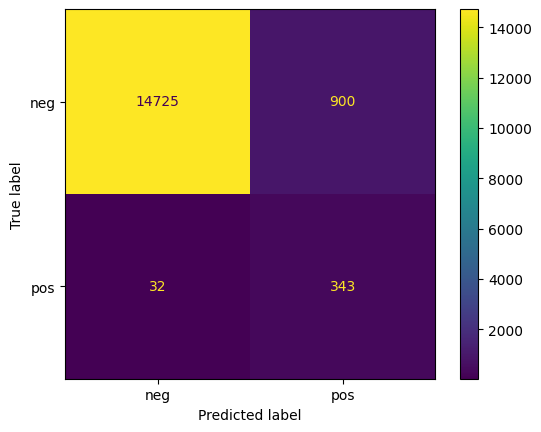

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['neg', 'pos'])
disp.plot()
plt.show()

In [ ]:
true_negative = cm[0][0]
false_positive = cm[0][1]
false_negative = cm[1][0]
true_positive = cm[1][1]
print(f'Costs with necessary early maintenance: {true_positive * 25}$')
print(f'Costs with unnecessary maintenance: {false_positive * 10}$')
print(f'Costs with corrective maintenance: {false_negative * 500}$')
print(f'Total cost: {false_positive * 10 + true_positive * 25 + false_negative * 500}$')

Costs with necessary early maintenance: 8575$
Costs with unnecessary maintenance: 9000$
Costs with corrective maintenance: 16000$
Total cost: 33575$


In [ ]:
precision_score(y_test,y_pred)

0.2759452936444087

In [ ]:
recall_score(y_test,y_pred)

0.9146666666666666

In [ ]:
f1_score(y_test,y_pred)

0.4239802224969098

In [ ]:
model = DecisionTreeClassifier(criterion='entropy')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

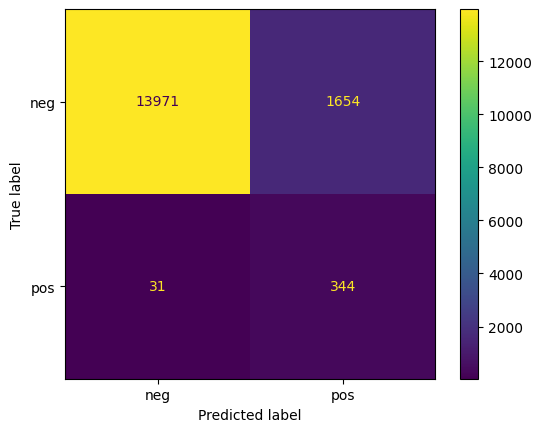

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['neg', 'pos'])
disp.plot()
plt.show()

In [ ]:
true_negative = cm[0][0]
false_positive = cm[0][1]
false_negative = cm[1][0]
true_positive = cm[1][1]
print(f'Costs with necessary early maintenance: {true_positive * 25}$')
print(f'Costs with unnecessary maintenance: {false_positive * 10}$')
print(f'Costs with corrective maintenance: {false_negative * 500}$')
print(f'Total cost: {false_positive * 10 + true_positive * 25 + false_negative * 500}$')

Costs with necessary early maintenance: 8600$
Costs with unnecessary maintenance: 16540$
Costs with corrective maintenance: 15500$
Total cost: 40640$


In [ ]:
precision_score(y_test,y_pred)

0.17217217217217218

In [ ]:
recall_score(y_test,y_pred)

0.9173333333333333

In [ ]:
f1_score(y_test,y_pred)

0.289928360724821

In [ ]:
model = RandomForestClassifier(n_estimators=100,criterion='entropy', max_depth=32)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

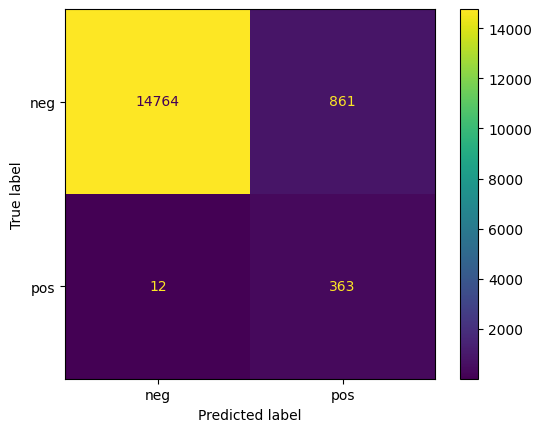

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['neg', 'pos'])
disp.plot()
plt.show()

In [ ]:
true_negative = cm[0][0]
false_positive = cm[0][1]
false_negative = cm[1][0]
true_positive = cm[1][1]
print(f'Costs with necessary early maintenance: {true_positive * 25}$')
print(f'Costs with unnecessary maintenance: {false_positive * 10}$')
print(f'Costs with corrective maintenance: {false_negative * 500}$')
print(f'Total cost: {false_positive * 10 + true_positive * 25 + false_negative * 500}$')

Costs with necessary early maintenance: 9075$
Costs with unnecessary maintenance: 8610$
Costs with corrective maintenance: 6000$
Total cost: 23685$


In [ ]:
precision_score(y_test,y_pred)

0.2965686274509804

In [ ]:
recall_score(y_test,y_pred)

0.968

In [ ]:
f1_score(y_test,y_pred)

0.4540337711069418

In [ ]:
len(X_test)

16000

In [ ]:
pca = PCA(n_components=2)
show = pca.fit_transform(X_test)
test = y_test.astype(str)
fig = px.scatter(show,x=show[:,0], y=show[:,1],color=test, width = 1000, height = 1000,title='Scatter Plot of test data colored by true label', labels={'x': 'PC1', 'y': 'PC2'})
fig

In [ ]:
pca = PCA(n_components=2)
show = pca.fit_transform(X_test)
pred = y_pred.astype(str)
fig = px.scatter(show,x=show[:,0], y=show[:,1],color=pred, width = 1000, height = 1000,title='Scatter Plot of test data colored by Random Forest label', labels={'x': 'PC1', 'y': 'PC2'})
fig

In [ ]:
best_sil = 0
sil_list = []
best_k = 0
k = range(2,16)
for i in k:
    model = KMeans(n_clusters=i,n_init=50)
    cluster = model.fit_predict(X_train)
    sil = silhouette_score(X_train,cluster)
    sil_list.append(sil)
    if sil > best_sil:
        best_sil = sil
        best_k = i

fig = px.line(x=k, y=sil_list)
fig

In [ ]:
model = KMeans(n_clusters=2,n_init=50)
model.fit(X_train)
cluster = model.predict(X_test)
pca = PCA(n_components=2)
show = pca.fit_transform(X_test)
fig = px.scatter(x=show[:,0], y=show[:,1],color=cluster.astype(str), width = 1000, height = 1000,title='Scatter Plot of test data colored by K-Means clusters with K=2', labels={'x': 'PC1', 'y': 'PC2'})
fig

In [ ]:
silhouette_score(X_test,cluster)

0.6357672753067476

In [ ]:
jaccard_score(y_test,cluster)

0.3543123543123543

In [ ]:
rand_score(y_test,cluster)

0.9659723185824114

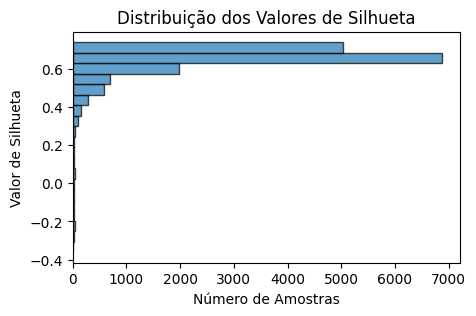

In [ ]:
silhouette_values = silhouette_samples(X_test,cluster)

plt.figure(figsize=(5, 3))
plt.hist(silhouette_values, bins=20, edgecolor='k', alpha=0.7, orientation='horizontal')
plt.title('Distribuição dos Valores de Silhueta')
plt.ylabel('Valor de Silhueta')
plt.xlabel('Número de Amostras')
plt.show()

In [ ]:

from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.metrics import silhouette_score, jaccard_score, adjusted_rand_score

model = AgglomerativeClustering(n_clusters=2)
model.fit(X_train)
cluster = model.fit_predict(X_test)

pca = PCA(n_components=2)
show = pca.fit_transform(X_test)

fig = px.scatter(x=show[:, 0], y=show[:, 1], color=cluster.astype(str), width=1000, height=1000,title='Scatter Plot of test data colored by Agglomerative Clustering with K=2',labels={'x': 'PC1', 'y': 'PC2'})
fig.show()

silhouette = silhouette_score(X_test, cluster)
jaccard = jaccard_score(y_test, cluster, pos_label=0)
rand = rand_score(y_test, cluster)

print(f'Silhouette Score: {silhouette}')
print(f'Jaccard Score: {jaccard}')
print(f'Adjusted Rand Score: {rand}')

KeyboardInterrupt: 